In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob, os
import rasterio
from datetime import datetime
import pickle
from nansat import Nansat, Domain, NSR
from tqdm import tqdm
from pyproj import Proj, transform

import requests
import zipfile

%load_ext autoreload
%autoreload 2

from sea_ice_drift.lib import get_spatial_mean, get_uint8_image
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching
from sea_ice_drift.libdefor import get_deformation_nodes
from functions import *

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import geemap
import ee
from datetime import datetime, timedelta

try:
  ee.Initialize(project = "ee-kooala317")
except:
  ee.Authenticate()
  ee.Initialize(project = "ee-kooala317")

## **Derive sea ice drift for the Weddell Sea**

## Sentinel-1 image from GEE

In [3]:
bound = {'north': -67, 'south': -77, 'west': -58, 'east': -43}
bound = [-59, -76, -45, -70]

In [4]:
Map = geemap.Map()
bound_ext = ee.Geometry.BBox(bound[0], bound[1], bound[2], bound[3]) #ee.Geometry.Rectangle(bbox)
Map.addLayer(bound_ext)
Map.centerObject(bound_ext, 5)
Map

Map(center=[-72.86886014135895, -51.999999999999844], controls=(WidgetControl(options=['position', 'transparen…

In [3]:
def get_S1_array(center, t1, t2, pixel_size = 60, distance = 100000, proj = "EPSG:3409"):
    # proj - EPSG:3409 (EASE South); EPSG:3976 (NSIDC south polar stereo); EPSG:3857 (Web Mercator)

    geometry = ee.Geometry.Point(center[0], center[1])
    
    if proj == "EPSG:3857":
        extent = geometry.buffer(distance = distance).bounds()
        dp = appropriate_resolution(center, pixel_size)
    else:
        extent = geometry.buffer(distance = distance, proj = proj).bounds(proj = proj)
        dp = pixel_size
    
    # Define necessary functions with the defined bbox --------------------------
    def collection_addbands(img):
        bands = img.bandNames() # First band ('HH' or 'VV')
        band = [ee.Algorithms.If(bands.contains('HH'), 'HH', 'VV')]
        norm = img.select(band).divide(img.select('angle')).rename('norm')
        img2 = img.addBands(norm, overwrite=True).select('norm')
        return img2
    def add_coverage(img):    
        tol = 10000
        overlap = img.geometry().intersection(extent, tol)
        ratio = overlap.area(tol).divide(extent.area(tol))
        return img.set({'coverage_ratio': ratio})
    # calculate coverage area of image to roi
    def coverage(img):
        tol = 10000
        overlap = img.geometry().intersection(extent, tol)
        ratio = overlap.area(tol).divide(extent.area(tol))
        return ratio.getInfo()
    # -------------------------------------------------------------------------
    
    collection0 = ee.ImageCollection("COPERNICUS/S1_GRD").filterBounds(extent).filterDate(t1, t2)\
    .filter(ee.Filter.eq('instrumentMode', 'EW'))
    
    collection1 = collection0.map(collection_addbands)
    collection = collection1.map(add_coverage).filter(ee.Filter.gt('coverage_ratio', 0.5)).sort('coverage_ratio', False)

    S1_ids = collection.aggregate_array('system:id').getInfo()    

    if len(S1_ids) > 0:
        # print(S1_ids, dp)
        S1_id = S1_ids[0]
        
        img = collection_addbands(ee.Image(S1_id)).setDefaultProjection(proj)
        #("EPSG:3857") #.reproject("EPSG:4326") # ("EPSG:3976") NSIDC southpolar
        img = add_coverage(img)

        name = os.path.basename(S1_id)[17:32]
        description = f"S1_{name}"                   
        
        img2 = img.clip(extent).select("norm")
            
        a = geemap.ee_to_numpy(img2, scale = dp)[:, :, 0]
        # a[a>=0] = np.nan

        return a, S1_id
        
    else:
        return np.array([]), ""

def get_bbox(center, distance):
    geometry = ee.Geometry.Point(center[0], center[1]).buffer(distance = distance).bounds()
    extent = np.array(geometry.getInfo()['coordinates'][0])

    east, north = extent[2] #np.max(extent, axis = 0)
    west, south = extent[0] #np.min(extent, axis = 0)

    if east > 180:
        east = -360 + east
    elif east < -180:
        east = 360 - east
    if west > 180:
        west = -360 + west
    elif west < -180:
        west = 360 - west

    bbox = [west, south, east, north]
    
    return bbox

In [4]:
# SIV database

def get_siv_mask(year):
    file = f"D:\\IS2_topo_DL\\SIV\\icemotion_weekly_sh_25km_{year}0101_{year}1231_v4.1.nc"
    
    with netCDF4.Dataset(file, 'r') as nc:
        xs = np.array(nc.variables['x']) #[20:-20]
        ys = np.array(nc.variables['y']) #[20:-20]
        xx1, yy1 = np.meshgrid(xs, ys)
        lat = np.array(nc.variables['latitude']) #[20:-20, 20:-20]
        lon = np.array(nc.variables['longitude']) #[20:-20, 20:-20]
        # lon = np.where(lon < 0, 360+lon, lon)
    
        # days = np.array(nc.variables['time']) #.astype(float)
        times = nc.variables['time']
        times = num2date(times[:], units = times.units)
        u = np.array(nc.variables['u']) #[:, 20:-20, 20:-20] 
        u[u < -9000] = np.nan
        u = u*0 + 1

    return xx1, yy1, lat, lon, u

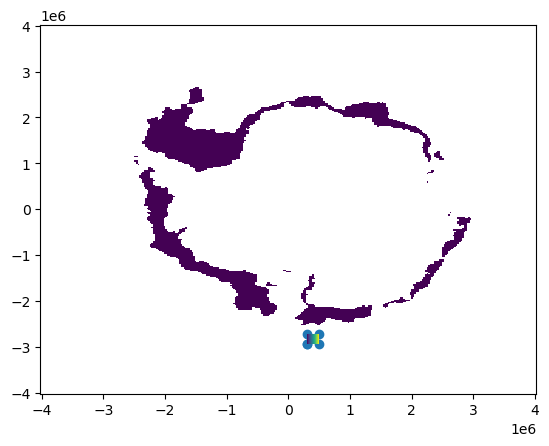

In [264]:
plt.pcolormesh(xx1, yy1, u[0])
plt.scatter(extent_coords[:, 0], extent_coords[:, 1])
plt.pcolormesh(x1pm, y1pm, x1pm)

In [252]:
map = geemap.Map()
map.addLayer(extent)
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Numpy direct

In [ ]:
######## START ###############################################################
w = [4, 1]
pixel_size = 100
step = 8
pm_step = 20
distance = 25000 * step / 2

proj = "EPSG:3409"
transformer = Transformer.from_crs(proj, "EPSG:4326")

for year in range(2024, 2025):
    
    xx1, yy1, lat, lon, u = get_siv_mask(year)
    row, col = lat.shape

    for ii in range(48, row, step):
        for jj in range(0, col, step):

            try:
                ee.Initialize(project = "utsa-spring2024")
            except:
                ee.Authenticate()
                ee.Initialize(project = "utsa-spring2024")
    
            clat = float(lat[ii, jj])
            clon = float(lon[ii, jj])
    
            center0 = np.array([clon, clat]) # lon, lat (Actually, it's upper right corner of the polygon)
            center = center0.copy()        
            
            geometry = ee.Geometry.Point(center[0], center[1])
            
            extent = geometry.buffer(distance = distance, proj = proj).bounds(proj = proj)
            bbox = [center[0]-w[0], center[1]-w[1], center[0], center[1]]        
            extent_coords = np.array(extent.coordinates().getInfo()[0])
            
            # lat0, lon0 = transformer.transform(extent_coords[:, 0], extent_coords[:, 1])
            # bbox = [lon0.min(), lon0.max(), lat0.min(), lat0.max()]        
            
            dp = pixel_size
            
            # Define necessary functions with the defined bbox --------------------------
            def collection_addbands(img):
                bands = img.bandNames() # First band ('HH' or 'VV')
                band = [ee.Algorithms.If(bands.contains('HH'), 'HH', 'VV')]
                norm = img.select(band).divide(img.select('angle')).rename('norm')
                img2 = img.addBands(norm, overwrite=True).select('norm')
                return img2
            def add_coverage(img):    
                tol = 10000
                overlap = img.geometry().intersection(extent, tol)
                ratio = overlap.area(tol).divide(extent.area(tol))
                return img.set({'coverage_ratio': ratio})
            # calculate coverage area of image to roi
            def coverage(img):
                tol = 10000
                overlap = img.geometry().intersection(extent, tol)
                ratio = overlap.area(tol).divide(extent.area(tol))
                return ratio.getInfo()
            # -------------------------------------------------------------------------
            
            for month in range(1, 13):    
    
                # pkl_name = f"D:\\NERC-NSF\\ice_vel\\ERA5_wind_{year}{str(month).zfill(2)}_{str(ii).zfill(3)}_{str(jj).zfill(3)}.pkl"
                
                # if os.path.exists(pkl_name) == False:
            
                ### LOAD SENTINEL-1 DATA FROM GOOGLE EARTH ENGINE AND SAVE AS NUMPY ARRAYS #######################
                start_date = f"{year}-{str(month).zfill(2)}-01" #02
                if month == 12:
                    end_date = f"{year+1}-01-01" #20
                else:
                    end_date = f"{year}-{str(month+1).zfill(2)}-01" #20
    
                jidx = int(datetime.strptime(start_date, "%Y-%m-%d").strftime("%j")) // 7
                
                pkl_era5 = f"D:\\NERC-NSF\\ice_vel\\ERA5_wind_{year}{str(month).zfill(2)}_{str(ii).zfill(3)}_{str(jj).zfill(3)}.pkl"
                
                if np.nansum(u[jidx:jidx+4, ii-step:ii+step, jj-step:jj+step]) > 4*(2*step)**2 * 0.3 and os.path.exists(pkl_era5) == False:
                    print(f"----- [{clon:.1f}, {clat:.1f} ({ii}, {jj})] {year} {str(month).zfill(2)} -----")
                    ##### LOAD AND SAVE ERA5 REANALYSIS DATA #######################
                    days = [str(i).zfill(2) for i in range(1, 32)]
                    ds, fl = retrieve_hourly_ERA5_bbox(year, str(month).zfill(2), days, bbox)
                
                    era_times = ds.valid_time.values
                    era_lat = ds.latitude.values
                    era_lon = ds.longitude.values
                    era_u10 = ds.u10.values
                    era_v10 = ds.v10.values
                    
                    pkl_save = [era_times, era_lat, era_lon, era_u10, era_v10, bbox]
                    try:
                        with open(pkl_era5, 'wb') as handle:
                            pickle.dump(pkl_save, handle)
                    except:
                        pkl_era5 = f"ERA5_wind_{year}{str(month).zfill(2)}_{str(ii).zfill(3)}_{str(jj).zfill(3)}.pkl"
                        with open(pkl_era5, 'wb') as handle:
                            pickle.dump(pkl_save, handle)                    
                    del ds
                    
                    try:
                        os.remove(fl)
                    except:
                        pass
                        
                    print("ERA5 data is loaded!")
                    ##### =====================================================================================
                    
                    d0 = datetime.strptime(start_date, "%Y-%m-%d")
                    d2 = datetime.strptime(end_date, "%Y-%m-%d")
                    
                    dn = abs(d2-d0).days
                    
                    map = geemap.Map()
                    array, times, Hs, Ws, xxs, yys = [], [], [], [], [], []
                    
                    for i in tqdm(range(dn)):
                    
                        t1 = (d0 + timedelta(days = i))
                        t2 = (d0 + timedelta(days = i+1))
                    
                        t1_str = t1.strftime("%Y-%m-%d")
                        
                        collection0 = ee.ImageCollection("COPERNICUS/S1_GRD").filterBounds(extent).filterDate(t1, t2)\
                        .filter(ee.Filter.eq('instrumentMode', 'EW'))
                        
                        collection1 = collection0.map(collection_addbands)
                        collection = collection1.map(add_coverage).filter(ee.Filter.gt('coverage_ratio', 0.3))
                    
                        S1_ids = collection.aggregate_array('system:id').getInfo()
                    
                        if len(S1_ids) > 1:
                            rs = collection.aggregate_array('coverage_ratio').getInfo()
                            S1_ids = [S1_ids[np.argmax(rs)]]
                    
                        for k in S1_ids:
                            
                            img = collection_addbands(ee.Image(k)).setDefaultProjection(proj)
                            img = add_coverage(img)
                    
                            name = os.path.basename(k)[17:32]
                            description = f"S1_{name}" 
                            # band_coord = ee.Image.pixelCoordinates(proj)
                            # img = img.addBands(band_coord)
                            img = img.clip(extent)                  
                            
                            img2 = img.select("norm")
                            # xx2 = img.select("x")
                            # yy2 = img.select("y")
                                
                            a = geemap.ee_to_numpy(img2, scale = dp)[:, :, 0]
                            # xx = geemap.ee_to_numpy(xx2, scale = dp)[:, :, 0]
                            # yy = geemap.ee_to_numpy(yy2, scale = dp)[:, :, 0]
                            
                            a[a>=0] = np.nan
                            array.append(a)
                            Hs.append(a.shape[0])
                            Ws.append(a.shape[1])
                            # xxs.append(xx)
                            # yys.append(yy)
                            times.append(datetime.strptime(description[-15:], "%Y%m%dT%H%M%S"))
    
                    if len(array) > 1:
                        H_target = np.bincount(Hs).argmax()
                        W_target = np.bincount(Ws).argmax()
                        ind_target = np.where((Hs == H_target) & (Ws == W_target))[0]
            
                        array1 = np.zeros([len(ind_target), H_target, W_target])
                        for i, n in enumerate(ind_target):
                            array1[i] = array[n]
                        
                        # del array
                    
                        print("SAR images: ", array1.shape[0])
                        
                        x0 = str(center[0].round(1))
                        y0 = str(center[1].round(1))
                        
                        # pkl_name = f"D:\\Landfast\\numpy_image\\S1_img_{year}{str(month).zfill(2)}_{x0}_{y0}.pkl"
                        # pkl_object = [array1, times, bbox]
                        # with open(pkl_name, 'wb') as handle:
                        #     pickle.dump(pkl_object, handle)
                    
                        ### DERIVE AND SAVE SEA ICE DRIFT #######################
                        ind_final1 = []
                        ind_final2 = []
                        pkl_objects = []
                        upms = []
                        vpms = []
                        apms = []
                        rpms = []
                        hpms = []
                        xpms = []
                        ypms = []
                        
                        for ind1 in range(0, array1.shape[0]-1):
                            ind2 = ind1 + 1
                            pkl_object = derive_drift(array1[ind1], array1[ind2], times[ind1], times[ind2], extent_coords, pixel_size, pm_step = pm_step)
                        
                            if len(pkl_object) > 0:
                                # pkl_objects.append(pkl_object)
                                upm, vpm, apm, rpm, hpm, xpm, ypm = pkl_object
                                upms.append(upm)
                                vpms.append(vpm)
                                apms.append(apm)
                                rpms.append(rpm)
                                hpms.append(hpm)
                                xpms.append(xpm)
                                ypms.append(ypm)
                                
                                if ind1 not in ind_final1:
                                    ind_final1.append(ind1)
                                if ind2 not in ind_final2:
                                    ind_final2.append(ind2)
                        
                        upms = np.array(upms)
                        vpms = np.array(vpms)
                        apms = np.array(apms)
                        rpms = np.array(rpms)
                        hpms = np.array(hpms)
                        xpms = np.array(xpms)
                        ypms = np.array(ypms)
    
                        if len(upms) > 0:
                        
                            pkl_objects = [upms, vpms, apms, rpms, hpms, xpms, ypms]                            
                            
                            pkl_save = [pkl_objects, ind_final1, ind_final2, times, extent_coords]
                            try:
                                pkl_s1 = f"D:\\NERC-NSF\\ice_vel\\S1_vel_{year}{str(month).zfill(2)}_{str(ii).zfill(3)}_{str(jj).zfill(3)}.pkl"
                                with open(pkl_s1, 'wb') as handle:
                                    pickle.dump(pkl_save, handle)
                            except:
                                pkl_s1 = f"S1_vel_{year}{str(month).zfill(2)}_{str(ii).zfill(3)}_{str(jj).zfill(3)}.pkl"
                                with open(pkl_s1, 'wb') as handle:
                                    pickle.dump(pkl_save, handle)                            
                
                            print(f"Ice drift tracking: {len(ind_final1)}")
                            del pkl_objects, upms, vpms, apms, rpms, hpms, xpms, ypms, array, array1

print("Done!")

In [19]:
with open(pkl_era5, 'wb') as handle:
    pickle.dump(pkl_save, handle)

In [10]:
os.path.exists(pkl_name)

True

In [258]:
extent_coords

extent_coords[:, 0], extent_coords[:, 1]

xmax = extent_coords[:, 0].max()
xmin = extent_coords[:, 0].min()
ymax = extent_coords[:, 1].max()
ymin = extent_coords[:, 1].min()

(2001, 1790)
(2001, 2001)
(1687, 1468)
(2001, 2001)
(2001, 2001)
(1687, 1469)
(2001, 2001)
(2001, 1790)


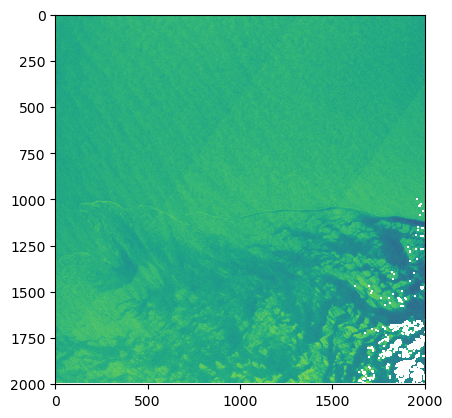

In [205]:
for a in array:
    print(a.shape)


In [262]:
a1, a2, t2, t1, pixel_size = array1[ind1], array1[ind2], times[ind1], times[ind2], pixel_size
pm_step = 30

a1 = prepare_array(a1)
a2 = prepare_array(a2)

t1_str = t1.strftime("%Y%m%dT%H%M%S")
t2_str = t2.strftime("%Y%m%dT%H%M%S")

dsec = abs(t2-t1).total_seconds()/3600 # seconds to hour
# print("Time difference (seconds): ", dsec)

# Process image =====================================================
# subsampling for lon/lat grids

srs = NSR(3409) #dstCrs = {'init': 'EPSG:32721'}

rows, cols = a1.shape

# -tr resolutionx resolutiony
# -ts sizex sizey
# -te xmin ymin xmax ymax
# -lle lonmin latmin lonmax latmax

d = Domain(srs.wkt, f'-te {xmin} {ymin} {xmax} {ymax} -ts {cols} {rows}')
n1 = Nansat.from_domain(d, a1)
n2 = Nansat.from_domain(d, a2)
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=20000, ratio_test=0.7, max_drift=40000, verbose=False)

# print(c1)

if len(c1) > 0:
    # convert row/column coordinates of matched features to lon/lat
    lon1ft, lat1ft = n1.transform_points(c1, r1)
    lon2ft, lat2ft = n2.transform_points(c2, r2)
    
    # get lon/lat coordinates of the border of images
    lon1b, lat1b = n1.get_border()
    lon2b, lat2b = n2.get_border()
    
    lon1pm, lat1pm = d.get_geolocation_grids(pm_step)
    x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)

In [263]:
x1pm

array([[303386.79039911, 306385.29114873, 309383.79189836, ...,
        495290.83837512, 498289.33912474, 501287.83987437],
       [303386.79039911, 306385.29114873, 309383.79189836, ...,
        495290.83837512, 498289.33912474, 501287.83987437],
       [303386.79039911, 306385.29114873, 309383.79189836, ...,
        495290.83837512, 498289.33912474, 501287.83987437],
       ...,
       [303386.79039911, 306385.29114873, 309383.79189836, ...,
        495290.83837512, 498289.33912474, 501287.83987437],
       [303386.79039911, 306385.29114873, 309383.79189836, ...,
        495290.83837512, 498289.33912474, 501287.83987437],
       [303386.79039911, 306385.29114873, 309383.79189836, ...,
        495290.83837512, 498289.33912474, 501287.83987437]])

In [244]:
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2, srs=srs.ExportToProj4())

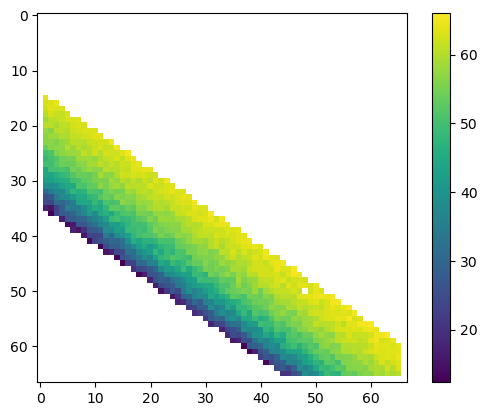

In [248]:
plt.imshow(lon2pm)
plt.colorbar()

In [241]:
lon1pm

array([[     0.,   3000.,   6000., ..., 192000., 195000., 198000.],
       [     0.,   3000.,   6000., ..., 192000., 195000., 198000.],
       [     0.,   3000.,   6000., ..., 192000., 195000., 198000.],
       ...,
       [     0.,   3000.,   6000., ..., 192000., 195000., 198000.],
       [     0.,   3000.,   6000., ..., 192000., 195000., 198000.],
       [     0.,   3000.,   6000., ..., 192000., 195000., 198000.]])

In [217]:
lon1pm, lat1pm = d.get_geolocation_grids(pm_step)
lon1pm.shape

(57, 53)

In [225]:
lon1pm

array([[ 0.        ,  1.01577618,  2.03091424, ..., 41.55778471,
        42.1216305 , 42.67561703],
       [ 0.        ,  1.03410754,  2.0675418 , ..., 42.06710696,
        42.6319749 , 43.1867727 ],
       [ 0.        ,  1.05311263,  2.10551419, ..., 42.58666357,
        43.15238973, 43.70783311],
       ...,
       [ 0.        , 22.61986495, 39.80557109, ..., 87.25191182,
        87.30571571, 87.35745471],
       [ 0.        , 35.53767779, 55.0079798 , ..., 88.39613723,
        88.42756957, 88.45779387],
       [ 0.        , 68.19859051, 78.69006753, ..., 89.54164354,
        89.55063055, 89.55927193]])

### Image download

In [ ]:
def collection_addbands(img):
    bands = img.bandNames() # First band ('HH' or 'VV')
    band = [ee.Algorithms.If(bands.contains('HH'), 'HH', 'VV')]
    norm = img.select(band).divide(img.select('angle')).rename('norm')
    img2 = img.addBands(norm, overwrite=True).select('norm')
    return img2

def add_coverage(img, extent = extent):
    
    tol = 10000
    overlap = img.geometry().intersection(extent, tol)
    ratio = overlap.area(tol).divide(extent.area(tol))
    return img.set({'coverage_ratio': ratio})

# calculate coverage area of image to roi
def coverage(img, extent):
    tol = 10000
    overlap = img.geometry().intersection(extent, tol)
    ratio = overlap.area(tol).divide(extent.area(tol))
    return ratio.getInfo()

start_date = "2018-09-01" #02
end_date = "2018-10-31" #20

d0 = datetime.strptime(start_date, "%Y-%m-%d")
d2 = datetime.strptime(end_date, "%Y-%m-%d")

dn = abs(d2-d0).days

map = geemap.Map()

for i in range(dn):

    t1 = (d0 + timedelta(days = i))
    t2 = (d0 + timedelta(days = i+1))

    t1_str = t1.strftime("%Y-%m-%d")
    
    collection0 = ee.ImageCollection("COPERNICUS/S1_GRD").filterBounds(extent).filterDate(t1, t2)\
    .filter(ee.Filter.eq('instrumentMode', 'EW'))
    
    collection1 = collection0.map(collection_addbands)
    collection = collection1.map(add_coverage).filter(ee.Filter.gt('coverage_ratio', 0.7))

    S1_ids = collection.aggregate_array('system:id').getInfo()
        
    # print(t1, t2, len(S1_ids))

    # print(start_date, end_date, len(S1_ids))

    if len(S1_ids) > 1:
        rs = collection.aggregate_array('coverage_ratio').getInfo()
        S1_ids = [S1_ids[np.argmax(rs)]]

    for k in S1_ids:
        
        img = collection_addbands(ee.Image(k)).setDefaultProjection("EPSG:3857") #("EPSG:3857") #.reproject("EPSG:4326")
        img = add_coverage(img)

        mrange = range(0, rows)
        nrange = range(0, cols)

        out_dir = "D:\Eddies\S1_eddies"
        geemap.download_ee_image_tiles(
            img, ee.FeatureCollection(extent), out_dir, prefix=f"s1_{t1_str}_", crs="EPSG:3857", scale=dp
        )

        # array = np.zeros([len(mrange)*2400, len(nrange)*2400])
        
        r = img.get('coverage_ratio').getInfo()
        # img = collection.reduce(ee.Reducer.median()).select('norm_median').clip(region)

        name = os.path.basename(k)[17:32]
        description = f"S1_{name}"

        # a = geemap.ee_to_numpy(img, scale = dp)
        # array.append(a)
        # days.append(t1)
        
        print(description, r)
        

Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-01_1.tif download size (raw: 1.26 GB).


s1_2018-09-01_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 113.99481678009033 seconds.
S1_20180901T075438 0.9470393927363248


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-02_1.tif download size (raw: 1.26 GB).


s1_2018-09-02_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 118.15346145629883 seconds.
S1_20180902T074528 0.9073411533207932


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-03_1.tif download size (raw: 1.26 GB).


s1_2018-09-03_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 122.38756966590881 seconds.
S1_20180903T073812 0.9918406932655337


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-06_1.tif download size (raw: 1.26 GB).


s1_2018-09-06_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 104.99851870536804 seconds.
S1_20180906T080234 0.8433660757711265


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-07_1.tif download size (raw: 1.26 GB).


s1_2018-09-07_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 118.30421471595764 seconds.
S1_20180907T075345 0.9685802566334515


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-08_1.tif download size (raw: 1.26 GB).


s1_2018-09-08_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 120.28469705581665 seconds.
S1_20180908T074614 0.9700820870832472


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-09_1.tif download size (raw: 1.26 GB).


s1_2018-09-09_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 119.87473940849304 seconds.
S1_20180909T073725 0.9947959986248036


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-10_1.tif download size (raw: 1.26 GB).


s1_2018-09-10_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 118.07758259773254 seconds.
S1_20180910T072958 0.8920612076163376


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-12_1.tif download size (raw: 1.26 GB).


s1_2018-09-12_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 106.29089403152466 seconds.
S1_20180912T080154 0.859994016018347


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-13_1.tif download size (raw: 1.26 GB).


s1_2018-09-13_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 115.72850275039673 seconds.
S1_20180913T075438 0.9470150710351196


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-14_1.tif download size (raw: 1.26 GB).


s1_2018-09-14_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 124.37215375900269 seconds.
S1_20180914T074528 0.9073505668261668


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-15_1.tif download size (raw: 1.26 GB).


s1_2018-09-15_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 115.627690076828 seconds.
S1_20180915T073812 0.9918373048326302


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-16_1.tif download size (raw: 1.26 GB).


s1_2018-09-16_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 107.52686381340027 seconds.
S1_20180916T072914 0.8906336582868617


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-18_1.tif download size (raw: 1.26 GB).


s1_2018-09-18_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 115.3432822227478 seconds.
S1_20180918T080234 0.843559673318133


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-19_1.tif download size (raw: 1.26 GB).


s1_2018-09-19_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 117.78245091438293 seconds.
S1_20180919T075346 0.9686879486880012


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-20_1.tif download size (raw: 1.26 GB).


s1_2018-09-20_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 117.88543725013733 seconds.
S1_20180920T074615 0.9700790996501774


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-21_1.tif download size (raw: 1.26 GB).


s1_2018-09-21_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 120.16597771644592 seconds.
S1_20180921T073726 0.9947356795424144


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-22_1.tif download size (raw: 1.26 GB).


s1_2018-09-22_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 105.25398659706116 seconds.
S1_20180922T072958 0.891880780626682


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-24_1.tif download size (raw: 1.26 GB).


s1_2018-09-24_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 106.07610321044922 seconds.
S1_20180924T080154 0.8599954458537935


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-25_1.tif download size (raw: 1.26 GB).


s1_2018-09-25_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 115.9787666797638 seconds.
S1_20180925T075438 0.9469975633904661


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-26_1.tif download size (raw: 1.26 GB).


s1_2018-09-26_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 106.70106601715088 seconds.
S1_20180926T074528 0.9073405069568565


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-27_1.tif download size (raw: 1.26 GB).


s1_2018-09-27_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 118.18825149536133 seconds.
S1_20180927T073812 0.9918958435037846


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-28_1.tif download size (raw: 1.26 GB).


s1_2018-09-28_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 106.50257587432861 seconds.
S1_20180928T072915 0.8907670711821679


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-09-30_1.tif download size (raw: 1.26 GB).


s1_2018-09-30_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 101.52798318862915 seconds.
S1_20180930T080235 0.8436595979708916


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-10-01_1.tif download size (raw: 1.26 GB).


s1_2018-10-01_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 107.50702619552612 seconds.
S1_20181001T173911 0.8969703296120585


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-10-02_1.tif download size (raw: 1.26 GB).


s1_2018-10-02_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 113.006108045578 seconds.
S1_20181002T074615 0.9700613672226681


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-10-03_1.tif download size (raw: 1.26 GB).


s1_2018-10-03_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 117.51891493797302 seconds.
S1_20181003T073726 0.9946627045062781


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-10-04_1.tif download size (raw: 1.26 GB).


s1_2018-10-04_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 103.35397815704346 seconds.
S1_20181004T072958 0.8912847917079795


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-10-06_1.tif download size (raw: 1.26 GB).


s1_2018-10-06_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 105.35781478881836 seconds.
S1_20181006T080155 0.8602744457927568


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-10-07_1.tif download size (raw: 1.26 GB).


s1_2018-10-07_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 113.35803389549255 seconds.
S1_20181007T075439 0.9471380285178708


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-10-08_1.tif download size (raw: 1.26 GB).


s1_2018-10-08_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 104.82539463043213 seconds.
S1_20181008T074529 0.9072611102724598


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-10-09_1.tif download size (raw: 1.26 GB).


s1_2018-10-09_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

Downloaded 1 tiles in 115.09260034561157 seconds.
S1_20181009T073813 0.9918759901621361


Consider adjusting `region`, `scale` and/or `dtype` to reduce the s1_2018-10-10_1.tif download size (raw: 1.26 GB).


s1_2018-10-10_1.tif: |                                                | 0.00/1.26G (raw) [  0.0%] in 00:00 (et…

## Summarized version for bulk processing

In [4]:
files

['D:\\Eddies\\S1_eddies\\S1_20181002T074615.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181003T073726.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181004T072958.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181005T072054.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181006T080155.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181007T075439.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181008T074529.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181009T073813.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181010T072915.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181011T072144.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181012T080235.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181013T075346.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181014T074615.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181015T073726.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181016T072958.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181017T072054.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181018T080155.tif',
 'D:\\Eddies\\S1_eddies\\S1_20181019T075439.tif']

In [9]:
img = rasterio.open(files[ind1])
a1 = img.read(1)
# img.close()

In [58]:
normz = Normalize(vmin = 0.2, vmax = 0.9)

In [21]:
# normalize array values
def prepare_array(img):
    # img = (img+1)/(1)
    img -= get_spatial_mean(img)
    img = get_uint8_image(img, None, None, 1, 99)
    return img

files = sorted(glob.glob(f"D:\\Eddies\\S1_eddies\\S1_*.tif"))
drawing = True
# print(len(files))

for i in range(5, len(files)-1):

    # Image read ==============================================
    ind1 = i
    ind2 = i+1
    
    t1 = datetime.strptime(os.path.basename(files[ind1])[-19:-4], "%Y%m%dT%H%M%S")
    t2 = datetime.strptime(os.path.basename(files[ind2])[-19:-4], "%Y%m%dT%H%M%S")

    t1_str = t1.strftime("%Y%m%dT%H%M%S")
    t2_str = t2.strftime("%Y%m%dT%H%M%S")

    if t2.year >= 2010:
    
        img = rasterio.open(files[ind1])
        # print(files[ind1])
        a1 = img.read(1)
        img.close()
        
        img = rasterio.open(files[ind2])
        # print(files[ind2])
        a2 = img.read(1)
        img.close()        
        
        a1 = prepare_array(a1)
        a2 = prepare_array(a2)
        
        ds = abs(t2-t1).total_seconds()
        print("Time difference (seconds): ", ds)
    
        # Process image =====================================================
        pixel_size = 50 # meters for fake grid
        pm_step = 50 # subsampling for lon/lat grids

        srs = NSR(32631) #dstCrs = {'init': 'EPSG:32721'}
        
        rows, cols = a1.shape
    
        d = Domain(srs.wkt, f'-te 0 0 {cols*pixel_size} {rows*pixel_size} -ts {cols} {rows}')
        n1 = Nansat.from_domain(d, a1)
        n2 = Nansat.from_domain(d, a2)
        c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=50000, ratio_test=0.5, max_drift=20000, verbose=False)
        
        if len(c1) > 10:
            # convert row/column coordinates of matched features to lon/lat
            lon1ft, lat1ft = n1.transform_points(c1, r1)
            lon2ft, lat2ft = n2.transform_points(c2, r2)
            
            # get lon/lat coordinates of the border of images
            lon1b, lat1b = n1.get_border()
            lon2b, lat2b = n2.get_border()
            
            lon1pm, lat1pm = d.get_geolocation_grids(pm_step)
            upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2, srs=srs.ExportToProj4())
        
            ## Draw maps of sea ice velocity ==============================================
            # plot valid vectors in Polar stereographic projection
            gpi = (rpm > 0.4) 
            # X/Y grids in polar stereographic projection covering image_1
            x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)
            
            # spacial reference for plotting
            crs = ccrs.UTM(zone=31, southern_hemisphere=False)

            ### SAVE AS PICKLE =======================================================
            pkl_name = f"D:\\Eddies\\ice_vel\\pickle\\S1_vel_{t1_str}_{t2_str}.pkl"
            pkl_object = [upm, vpm, apm, rpm, hpm, lon2pm, lat2pm]
            with open(pkl_name, 'wb') as handle:
                pickle.dump(pkl_object, handle)
            print(pkl_name)
            
            ### DRAW MAP of ICE VELOCITY =============================================
            if drawing:
                plt.figure(figsize=(8,8), dpi = 180)
                ax = plt.axes(projection=crs)
        
                normz = Normalize(vmin = 0.2, vmax = 0.9)
                
                ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper', vmin = 100, vmax = 250)
                quiv=ax.quiver(x1pm[gpi], y1pm[gpi], upm[gpi]/ds*3600*24, vpm[gpi]/ds*3600*24, rpm[gpi],
                               cmap='jet', width=0.002, angles='xy', scale_units='xy', scale=1, norm = normz)
                plt.colorbar(quiv, shrink=0.5)
                # plt.quiverkey(quiv, x1pm.max(), y1pm.max(), 0.05, '0.05 m/s', coordinates='data')
                plt.title('Ice drfit speed [m/day]')
                # ax.add_feature(land_50m, edgecolor='black')
                ax.set_xticks(np.arange(x1pm.min(), x1pm.max(), 25000))
                ax.set_yticks(np.arange(0, y1pm.max(), 25000))
                
                ax.set_xlim([x1pm.min() - pixel_size*pm_step, x1pm.max() + pixel_size*pm_step])
                ax.set_ylim([y1pm.min() - pixel_size*pm_step, y1pm.max() + pixel_size*pm_step])
                
                # plt.show()            
                imgname = f"D:\\Eddies\\ice_vel\\maps\\S1_vel_{t1_str}_{t2_str}.png"
                print(imgname)
                plt.savefig(imgname, bbox_inches = "tight")
                plt.close()
            
print("Done")

Time difference (seconds):  85850.0


C:\Users\yoko2261\Research\sea_ice_drift\sea_ice_drift\pmlib.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


100% 04700.0 08050.0 0000nan 0000nan +0nan 0nan 0nan
 Pattern matching - OK! ( 55 sec)
D:\Eddies\ice_vel\pickle\S1_vel_20181007T075439_20181008T074529.pkl
D:\Eddies\ice_vel\maps\S1_vel_20181007T075439_20181008T074529.png
Time difference (seconds):  85964.0


C:\Users\yoko2261\Research\sea_ice_drift\sea_ice_drift\pmlib.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


100% 05850.0 07050.0 05813.0 07968.0 -03.0 0.00 0nan
 Pattern matching - OK! ( 61 sec)
D:\Eddies\ice_vel\pickle\S1_vel_20181008T074529_20181009T073813.pkl
D:\Eddies\ice_vel\maps\S1_vel_20181008T074529_20181009T073813.png
Time difference (seconds):  85862.0


C:\Users\yoko2261\Research\sea_ice_drift\sea_ice_drift\pmlib.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


100% 01400.0 07350.0 0000nan 0000nan +0nan 0nan 0nan
 Pattern matching - OK! ( 67 sec)
D:\Eddies\ice_vel\pickle\S1_vel_20181009T073813_20181010T072915.pkl
D:\Eddies\ice_vel\maps\S1_vel_20181009T073813_20181010T072915.png
Time difference (seconds):  85949.0


C:\Users\yoko2261\Research\sea_ice_drift\sea_ice_drift\pmlib.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


100% 06300.0 08050.0 0000nan 0000nan +0nan 0nan 0nan
 Pattern matching - OK! ( 53 sec)
D:\Eddies\ice_vel\pickle\S1_vel_20181010T072915_20181011T072144.pkl
D:\Eddies\ice_vel\maps\S1_vel_20181010T072915_20181011T072144.png
Time difference (seconds):  88851.0


C:\Users\yoko2261\Research\sea_ice_drift\sea_ice_drift\pmlib.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


100% 07150.0 07900.0 07589.0 07774.0 -03.0 0.00 0nan
 Pattern matching - OK! ( 44 sec)
D:\Eddies\ice_vel\pickle\S1_vel_20181011T072144_20181012T080235.pkl
D:\Eddies\ice_vel\maps\S1_vel_20181011T072144_20181012T080235.png
Time difference (seconds):  85871.0
Time difference (seconds):  85949.0
Time difference (seconds):  85871.0
Time difference (seconds):  85952.0
Time difference (seconds):  85856.0
Time difference (seconds):  88861.0
Time difference (seconds):  85964.0
Done
